# Keras MNIST tutorial

https://elitedatascience.com/keras-tutorial-deep-learning-in-python

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

import os    
os.environ['THEANO_FLAGS'] = "device=gpu0" 
import theano
print(theano.config.device)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras import optimizers
from keras import callbacks
from keras import backend as K
from pylab import *

import numpy as np
np.random.seed(123)  # for reproducibility

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:556: UserWarning: Theano flag device=gpu* (old gpu back-end) only support floatX=float32. You have floatX=float64. Use the new gpu back-end with device=cuda* for that value of floatX.
  warnings.warn(msg)
Using gpu device 0: GP10B (CNMeM is disabled, cuDNN 5110)


gpu0


Using Theano backend.


In [2]:
! pwd

/home/nvidia/keras/tutorials


### Load MNIST dataset

In [3]:
import os
from urllib import urlretrieve

def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# We then define functions for loading MNIST images and labels.
# For convenience, they also download the requested files if needed.
import gzip

def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    # Read the inputs in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    # The inputs are vectors now, we reshape them to monochrome 2D images,
    # following the shape convention: (examples, channels, rows, columns)
    data = data.reshape(-1, 1, 28, 28)
    # The inputs come as bytes, we convert them to float32 in range [0,1].
    # (Actually to range [0, 255/256], for compatibility to the version
    # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
    return data / np.float32(256)

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    # Read the labels in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    # The labels are vectors of integers now, that's exactly what we want.
    return data

In [4]:
X_train = load_mnist_images('train-images-idx3-ubyte.gz')
y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

In [5]:
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

(60000, 1, 28, 28)
(60000,)
(10000, 1, 28, 28)
(10000,)


0.996094


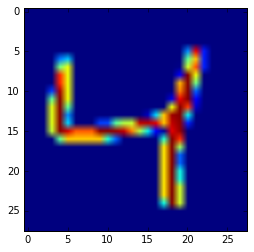

In [6]:
plt.imshow(X_train[2][0])
print np.amax(X_train[2][0])

In [7]:
print X_train.shape
print X_test.shape

(60000, 1, 28, 28)
(10000, 1, 28, 28)


In [8]:
# Convert to float32 and normalise to range [0,1]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
#X_train /= 255
#X_test /= 255

## Convert labels to 10 distinct class labels (one-hot)

In [9]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [10]:
print Y_train.shape
print y_train[:2]
print Y_train[:2]

(60000, 10)
[5 0]
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


# Step 7. Define model architecture

In [118]:
model = Sequential()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [119]:
model.add(Conv2D(32, (3, 3), data_format="channels_first",activation='tanh',input_shape=(1,28,28)))
model.add(Conv2D(32, (3, 3)))
layer_2 = Activation('relu')
model.add(layer_2)
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

In [120]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 26, 26)        320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 24, 32)        7520      
_________________________________________________________________
activation_5 (Activation)    (None, 30, 24, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 12, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5760)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5760)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                57610     
Total para

In [121]:
adm = optimizers.Adam(lr=0.01, decay=0.0005)
sgd = optimizers.SGD(lr=0.01, momentum=0.09, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd, metrics=['accuracy'])

In [171]:
class NBatchLogger(callbacks.Callback):
    def __init__(self,display=100):
        '''
        display: Number of batches to wait before outputting loss
        '''
        self.seen = 0
        self.display = display
        self.acc_train = []
        self.loss_train = []
        self.log_points = 0
        self.batches = 0
        self.acc_accum = 0
        self.loss_accum = 0

    def on_batch_end(self,batch,logs={}):
        self.seen += logs.get('size', 0)
        self.batches += 1
        #print logs
        #print self.batches,logs['acc'],logs['loss']
        self.acc_accum += logs['acc']
        self.loss_accum += logs['loss']
        if self.batches % self.display == 0:  
            self.acc_train.append(self.acc_accum/self.display)
            self.loss_train.append(self.loss_accum/self.display)
            self.log_points += 1
            self.acc_accum = 0
            self.loss_accum = 0
            print '{0}/{1} acc: {2} Loss: {3}'.format(self.seen,self.params['samples']*self.params['epochs'],
                                                logs['acc'],logs['loss'])

In [172]:
class BatchHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accurs = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accurs.append(logs.get('acc'))

# Step 9. Fit model on training data

In [184]:
samples = 60000 # batches to see in one epoch
batch_train_history = NBatchLogger(display=100)
print "using "+str(samples)+" samples"
history = model.fit(X_train[:samples], Y_train[:samples], validation_data=(X_test,Y_test), \
                      batch_size=64, epochs=6, verbose=0, callbacks=[batch_train_history])


using 60000 samples
6400/360000 acc: 0.984375 Loss: 0.0616024769843
12800/360000 acc: 0.96875 Loss: 0.156929343939
19200/360000 acc: 0.984375 Loss: 0.0829721242189
25600/360000 acc: 0.921875 Loss: 0.205728039145
32000/360000 acc: 0.96875 Loss: 0.0602442622185
38400/360000 acc: 0.96875 Loss: 0.171508818865
44800/360000 acc: 0.953125 Loss: 0.155588775873
51200/360000 acc: 0.921875 Loss: 0.119077630341
57600/360000 acc: 0.953125 Loss: 0.0939469859004
63968/360000 acc: 0.96875 Loss: 0.110011674464
70368/360000 acc: 0.921875 Loss: 0.276906251907
76768/360000 acc: 0.96875 Loss: 0.0876770317554
83168/360000 acc: 0.984375 Loss: 0.08440040797
89568/360000 acc: 0.96875 Loss: 0.136462926865
95968/360000 acc: 0.96875 Loss: 0.0712086185813
102368/360000 acc: 0.953125 Loss: 0.137152403593
108768/360000 acc: 0.953125 Loss: 0.139280319214
115168/360000 acc: 0.953125 Loss: 0.103466793895
121536/360000 acc: 0.96875 Loss: 0.298043131828
127936/360000 acc: 0.96875 Loss: 0.11385717243
134336/360000 acc: 0.

In [185]:
def plot_loss_accuracy(train_loss, test_loss, train_acc, test_acc, train_pars) :    
    niter = train_pars['niter']
    test_interval = train_pars['test_interval']
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    ax1.plot(arange(niter), train_loss, 'r-',label= "loss_train",alpha=0.3)
    ax1.plot(test_interval+test_interval * arange(len(test_acc)), test_loss, 'r.-',label= "loss_test")
    ax2.plot(arange(niter), train_acc, 'b-',label= "acc_train",alpha=0.7)
    ax2.plot(test_interval+test_interval * arange(len(test_acc)), test_acc, 'b.-',label= "acc_test")
    #ax1.set_ylim([0,9])
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('train loss')
    ax2.set_ylabel('test accuracy')

    ax2.set_ylim([0,1])
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

9.33333333333
56 6
{'niter': 56, 'test_interval': 9.333333333333334}


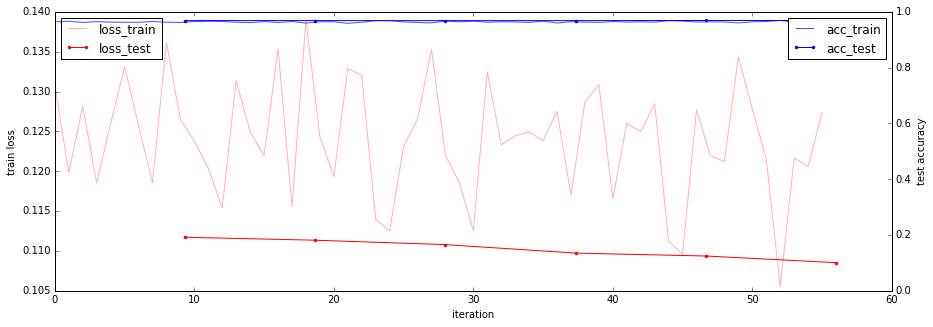

In [186]:
from __future__ import division
test_interv = batch_train_history.log_points / len(history.history['val_acc'])
print test_interv
train_pars={'niter':batch_train_history.log_points, 'test_interval': test_interv}
print batch_train_history.log_points, len(history.history['val_acc'])
print train_pars
plot_loss_accuracy(batch_train_history.loss_train, history.history['val_loss'], \
                   batch_train_history.acc_train,  history.history['val_acc'],  train_pars)   

In [141]:
print history.history
print  batch_train_history.log_points, \
    batch_train_history.display

{'acc': [0.89699999392032626, 0.89100000262260437, 0.90100000500679012], 'loss': [0.40996543690562248, 0.40646892338991164, 0.38387726768851282], 'val_acc': [0.85609999656677249, 0.86289999604225154, 0.86559999555349354], 'val_loss': [0.47583599027246237, 0.45694950975477694, 0.44713452573865653]}
60 10


In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
axes = plt.gca()
#axes.set_ylim([0,1.1])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'loss'], loc='upper left')
plt.show()

# Step 10. Evaluate model on test data

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=1)

In [ ]:
print score

# Visualise weights

In [89]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    plt.colorbar(im, cax=cax)

In [187]:
import numpy.ma as ma
def make_mosaic(imgs, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    dims = len(imgs.shape)
    if dims > 3:
        # Squash last dimentions
        print "Array has ",dims," dimensions"
        last_dim_shape = 1
        for d in range(2,dims):
            last_dim_shape *= imgs.shape[d]
        imgs = np.reshape(imgs,(imgs.shape[0],imgs.shape[1], last_dim_shape))
        print "New shape ", imgs.shape
        
    nimgs = imgs.shape[2]
    imshape = imgs.shape[:2]
    print nimgs, "images, shaped:",imshape 
    srt = math.sqrt(nimgs)
    nrows = int(math.floor(srt))
    ncols = nimgs // nrows + 1
    print nrows, "x", ncols
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[:,:,i]
    return mosaic

In [188]:
def show_weights(model, layer, layer_name):
    #layer_f = K.function(model.inputs, [layer.output])

    # Visualize weights
    W = model.layers[layer].kernel.get_value(borrow=True)
    W = np.squeeze(W)
    print("W shape : ", W.shape)

    plt.figure(figsize=(10, 10))
    plt.title(layer_name+' weights')
    nice_imshow(plt.gca(), make_mosaic(W), cmap=cm.binary)

('W shape : ', (3, 3, 32))
32 images, shaped: (3, 3)
5 x 7


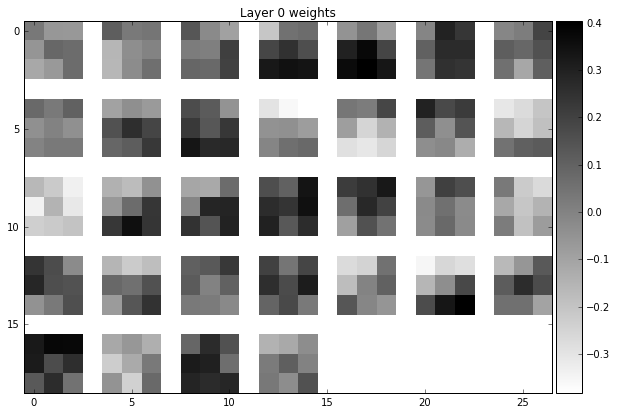

In [189]:
show_weights(model, 0, "Layer 0")

('W shape : ', (3, 3, 26, 32))
Array has  4  dimensions
New shape  (3, 3, 832)
832 images, shaped: (3, 3)
28 x 30


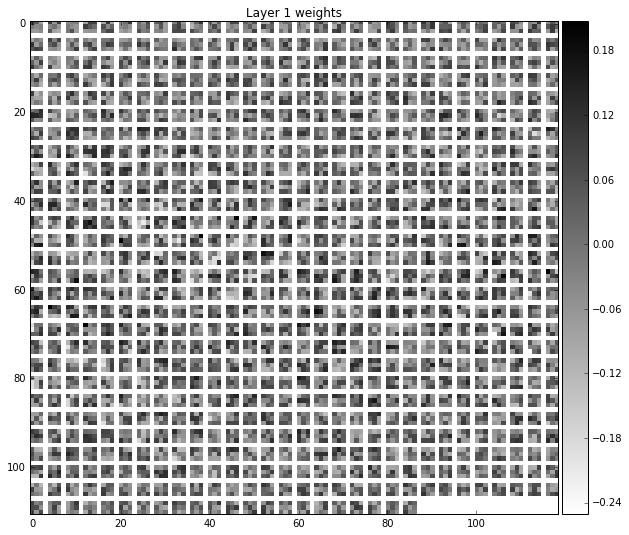

In [190]:
show_weights(model, 1, "Layer 1")